In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Gap Days

In [2]:
PROVIDED_DATA_DIR = 'data'
CREATED_DATA_DIR = 'data_created'

activity = pd.read_csv(f'{PROVIDED_DATA_DIR}/activity.csv')

In [3]:
# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

In [4]:
# Create new column for activity started day
activity['active_day'] = pd.to_datetime(activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

In [5]:
# Compute gaps between active days for each user
activity.sort_values(['user_id', 'active_day'], inplace=True)
activity['previous_day'] = activity.groupby('user_id')['active_day'].shift(1)
activity['gap_days'] = (activity['active_day'] - activity['previous_day']).dt.days

In [6]:
# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
activity = activity[columns]

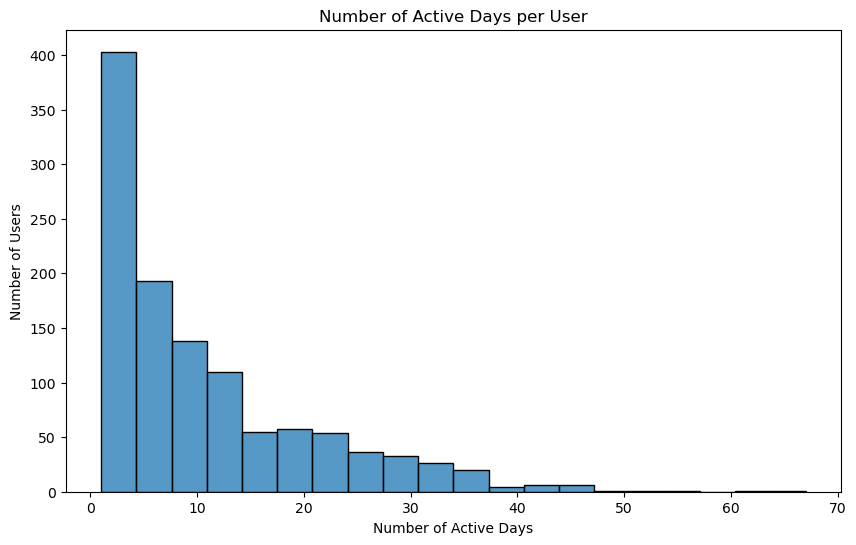

In [7]:
# Histogram of number of active days per user
plt.figure(figsize=(10, 6))
sns.histplot(activity['user_id'].value_counts(), bins=20)
plt.title('Number of Active Days per User')
plt.xlabel('Number of Active Days')
plt.ylabel('Number of Users')
plt.show()

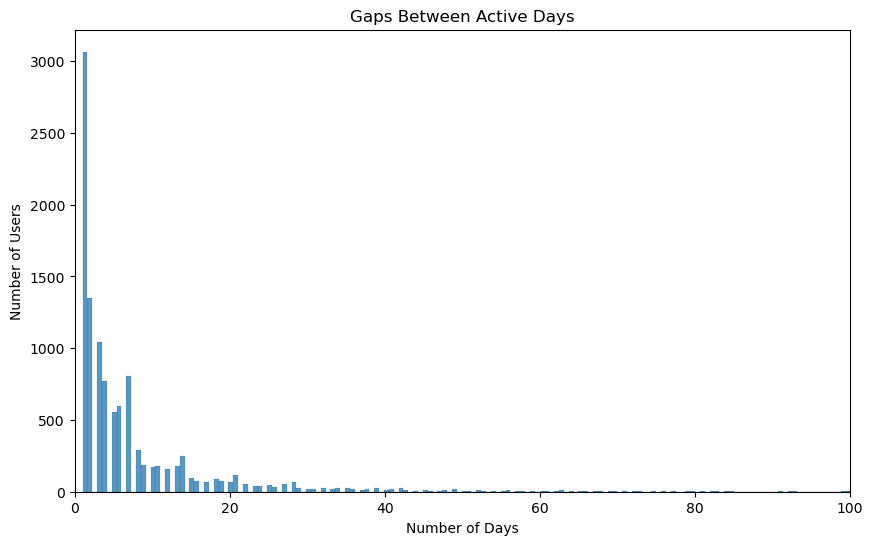

In [8]:
# Histogram of gaps between active days (x from 0 to 100 days)
plt.figure(figsize=(10, 6))
sns.histplot(activity['gap_days'])
plt.title('Gaps Between Active Days')
plt.xlabel('Number of Days')
plt.ylabel('Number of Users')
plt.xlim(0, 100)
plt.show()

In [9]:
display(activity.head())
print(f'Number of rows: {activity.shape[0]}')
print(f'Number of unique users: {activity.user_id.nunique()}')

,user_id,active_day,gap_days
31764,1,2024-10-26,NaN
34732,1,2024-10-30,4.0
35439,1,2024-10-31,1.0
35871,1,2024-11-01,1.0
36115,1,2024-11-02,1.0


Number of rows: 12237
Number of unique users: 1146


In [10]:
# Save the cleaned data
if not os.path.exists(CREATED_DATA_DIR):
    os.makedirs(CREATED_DATA_DIR)

activity.to_csv(f'{CREATED_DATA_DIR}/activity_cleaned.csv', index=False)